# Programming Assignment #6: Recurrent Neural Networks
Author: Pierre Nugues

## Objectives

The objectives of this assignment are to:
* Write a program to recognize named entities in text
* Learn how to manage a text data set
* Apply recurrent neural networks to text
* Know what word embeddings are
* Write a short report on your experiments. This report is mandatory to pass the assignment.

## Organization and location

You can work alone or collaborate with another student:
* Each group will have to write Python programs to recognize named entities in text.
* You will have to experiment different architectures, namely RNN and LSTM, and compare the results you obtained.
* Each student will have to write an individual report on these experiments.

## Imports

In [323]:
import sys
import regex as re
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Lambda, TimeDistributed
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.activations import softmax

EPOCHS = 15
LSTM_UNITS = 100

## Collecting a Dataset

1. You will use a dataset from the CoNLL conferences that benchmark natural language processing systems and tasks. There were two conferences on named entity recognition: <a href="https://www.clips.uantwerpen.be/conll2002/ner/">CoNLL 2002</a> (Spanish and Dutch) and <a href="https://www.clips.uantwerpen.be/conll2003/ner/">CoNLL 2003</a> (English and German). In this assignment, you will work on the English dataset. Read the description of the task.
2. The datasets are protected by a license and you normally need to obtain it to reconstruct the data. As a shortcut, your teacher created a local copy in Canvas. Please use it. See the link in the Canvas description of the lab.
3. Alternatively, you can try to find the dataset on github (type conll2003 in the search box) or use the Google dataset search: <a href="https://toolbox.google.com/datasetsearch">https://toolbox.google.com/datasetsearch</a>, but some programmers may have changed the annotation, which could be misleading. 
4. The dataset comes in the form of three files: a training set, a development set, and a test set. <!--, named:
    <tt>eng.train</tt>, <tt>eng.testa</tt> (validation), and <tt>eng.testb</tt> (test).-->

## Reading the Corpus

You will read the corpus with the cells below. The functions will enable you to load the files in the form of a list of dictionaries.

In [324]:
BASE_DIR = 'C:/Users/filip/Documents/Högskola/[EDAN95] - Applied Machine Learning/lab_6/corpus/'

In [325]:
def load_conll2003_en():
    train_file = BASE_DIR + 'NER-data/eng.train'
    dev_file = BASE_DIR + 'NER-data/eng.valid'
    test_file = BASE_DIR + 'NER-data/eng.test'
    column_names = ['form', 'ppos', 'pchunk', 'ner']
    train_sentences = open(train_file, encoding='utf8').read().strip()
    dev_sentences = open(dev_file, encoding='utf8').read().strip()
    test_sentences = open(test_file, encoding='utf8').read().strip()
    return train_sentences, dev_sentences, test_sentences, column_names

In [326]:
train_sentences, dev_sentences, test_sentences, column_names = load_conll2003_en()
train_sentences[:100]

'-DOCSTART- -X- O O\n\nEU NNP I-NP I-ORG\nrejects VBZ I-VP O\nGerman JJ I-NP I-MISC\ncall NN I-NP O\nto TO '

In [327]:
class Token(dict):
    pass


class CoNLLDictorizer:

    def __init__(self, column_names, sent_sep='\n\n', col_sep=' +'):
        self.column_names = column_names
        self.sent_sep = sent_sep
        self.col_sep = col_sep

    def fit(self):
        pass

    def transform(self, corpus):
        corpus = corpus.strip()
        sentences = re.split(self.sent_sep, corpus)
        return list(map(self._split_in_words, sentences))

    def fit_transform(self, corpus):
        return self.transform(corpus)

    def _split_in_words(self, sentence):
        rows = re.split('\n', sentence)
        return [Token(dict(zip(self.column_names,
                               re.split(self.col_sep, row))))
                for row in rows]

In [328]:
conll_dict = CoNLLDictorizer(column_names, col_sep=' +')
train_dict = conll_dict.transform(train_sentences)
dev_dict = conll_dict.transform(dev_sentences)
test_dict = conll_dict.transform(test_sentences)

In [329]:
train_dict[0]

[{'form': '-DOCSTART-', 'ppos': '-X-', 'pchunk': 'O', 'ner': 'O'}]

In [330]:
print('\n'.join(map(str, train_dict[1])))

{'form': 'EU', 'ppos': 'NNP', 'pchunk': 'I-NP', 'ner': 'I-ORG'}
{'form': 'rejects', 'ppos': 'VBZ', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'German', 'ppos': 'JJ', 'pchunk': 'I-NP', 'ner': 'I-MISC'}
{'form': 'call', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': 'to', 'ppos': 'TO', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'boycott', 'ppos': 'VB', 'pchunk': 'I-VP', 'ner': 'O'}
{'form': 'British', 'ppos': 'JJ', 'pchunk': 'I-NP', 'ner': 'I-MISC'}
{'form': 'lamb', 'ppos': 'NN', 'pchunk': 'I-NP', 'ner': 'O'}
{'form': '.', 'ppos': '.', 'pchunk': 'O', 'ner': 'O'}


## Evaluating your Models

You will train the models with the traiing set and the test set to evaluate them. For this, you will apply the `conlleval` script that will compute the harmonic mean of the precision and recall: F1. 

`conlleval` was written in Perl and you have a local copy of this script in `/usr/local/cs/EDAN95/datasets/ner/bin`. Some people rewrote it in Python and you will use such such a translation in this lab. The line below installs it.

In [331]:
!pip install conlleval
import conlleval

## Collecting the Embeddings

You will represent the words with the GloVe embeddings:
1. Either:
    * Download the GloVe embeddings 6B from <a href="https://nlp.stanford.edu/projects/glove/">https://nlp.stanford.edu/projects/glove/</a> and keep the 100d vectors; or
    * Use the local copy of this dataset in Canvas
2. Apply the function below that reads GloVe embeddings and store them in a dictionary, where the keys will be the words and the values, the embedding vectors.

In [332]:
embedding_file = 'C:/Users/filip/Documents/Högskola/[EDAN95] - Applied Machine Learning/lab_6/corpus/glove.6B.100d.txt'

In [333]:
def read_embeddings(file):
    """
    Return the embeddings in the from of a dictionary
    :param file:
    :return:
    """
    embeddings = {}
    glove = open(file, encoding='utf8')
    for line in glove:
        values = line.strip().split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embeddings[word] = vector
    glove.close()
    return embeddings

In [334]:
# We read the embeddings
embeddings_dict = read_embeddings(embedding_file)
embedded_words = sorted(list(embeddings_dict.keys()))
print('# words in embedding dictionary:', len(embedded_words))

# words in embedding dictionary: 400000


Using a cosine similarity, write a `closest(target_word, embeddings, count=10)` that computes the 10 closest words to the words _table_, _france_, and _sweden_.

In [335]:
from scipy import spatial

def cosine_similarity(a, b):
    return 1 - spatial.distance.cosine(a, b)

def closest(target_word, embeddings, count=10):
    target_embedding = embeddings[target_word]
    distances = [(word, cosine_similarity(target_embedding, embedding)) for word, embedding in zip(embeddings.keys(), embeddings.values())]
    closest_embeddings = sorted(distances, key=lambda x:-x[1])[:count]
    return list(map(lambda x:x[0], closest_embeddings))

In [336]:
closest('france', embeddings_dict)

['france',
 'belgium',
 'french',
 'britain',
 'spain',
 'paris',
 'germany',
 'italy',
 'europe',
 'netherlands']

In [337]:
closest('sweden', embeddings_dict)

['sweden',
 'denmark',
 'norway',
 'finland',
 'netherlands',
 'austria',
 'switzerland',
 'germany',
 'swedish',
 'belgium']

In [338]:
closest('table', embeddings_dict)

['table',
 'tables',
 'place',
 'bottom',
 'room',
 'side',
 'sit',
 'top',
 'here',
 'pool']

## Extracting the $\mathbf{X}$ and $\mathbf{Y}$ Lists of Symbols

Write a `build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True)` function that, for each sentence, returns the $\mathbf{x}$ and $\mathbf{y}$ lists of symbols consisting of words and NER tags.

For the second sentence of the training set, you should have:<br/>
<tt>x = ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']</tt><br/>
<tt>y = ['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']</tt><br/>
Some datasets you may find on the web use a different NER tagset, where <tt>I-</tt> is
replaced with <tt>B-</tt>, like <tt>B-ORG</tt> instead of <tt>I-ORG</tt>. This will not change the final results.

In [339]:
def build_sequences(corpus_dict, key_x='form', key_y='ner', tolower=True):
    X = list()
    Y = list()
    for i, sentence in enumerate(corpus_dict):
        X.append(list())
        Y.append(list())
        for word in sentence:
            X[i].append(word[key_x].lower())
            Y[i].append(word[key_y])
    return X, Y


# print(build_sequences(train_dict))

Apply this function to your datasets so that you create $\mathbf{X}_\text{train_symbs}$ and $\mathbf{Y}_\text{train_symbs}$ lists of lists consisting of words and NER tags.

In [340]:
X_train_symbs, Y_train_symbs = build_sequences(train_dict, key_x='form', key_y='ner')

In [341]:
X_train_symbs[1]

['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']

In [342]:
Y_train_symbs[1]

['I-ORG', 'O', 'I-MISC', 'O', 'O', 'O', 'I-MISC', 'O', 'O']

## Vocabulary

Create a vocabulary of all the words observed in the training set and the words in GloVe. You should find 402,595 different words. You will proceed in two steps.

First extract the list of unique words from the CoNLL training set and the list of NER tags. You will sort them

In [343]:
# Write your code: List of words and tags in CoNLL
# TODO: Something is wrong here guys. We get more words than we're supposed to have.....!!!!!!!!!!!
words, ner = set(), set()
for i, sentence in enumerate(train_dict):
    for word in sentence:
        words.add(word['form'].lower())
        ner.add(word['ner'])
words = sorted(list(words))
ner = sorted(list(ner))

In [344]:
print('# words seen in training corpus:', len(words))
print('# NER tags seen:', len(ner))
print(words[:10])

# words seen in training corpus: 21010
# NER tags seen: 8
['!', '"', '$', '%', '&', "'", "'d", "'ll", "'m", "'re"]


Then, merge the list of unique CoNLL words with the words in the embedding file. You will sort this list

In [345]:
# Write your code: Add vocabulary of embedded words
vocabulary_words = set()
for word in embeddings_dict.keys():
    vocabulary_words.add(word.lower())
vocabulary_words = vocabulary_words.union(words)
vocabulary_words = sorted(list(vocabulary_words))

In [346]:
# Our run
print('# words in the vocabulary: embeddings and corpus:', len(vocabulary_words))

# words in the vocabulary: embeddings and corpus: 402595


## Index

Create indices `word2idx`, `ner2idx` and inverted indices `idx2word`, `idx2ner` for the words and the NER: i.e. you will associate each word with a number. You will use index 0 for the padding symbol and 1 for unknown words. This means that your first word will start at index 2.

In [347]:
# Write your code:
word2idx = {}
idx2word = {}

for i, word in enumerate(vocabulary_words):
    if word in embeddings_dict:
        word2idx[word] = i + 2
        idx2word[i + 2] = word
    else:
        word2idx[word] = 1
        if 1 not in idx2word:
            idx2word[1] = [word]
        else:
            idx2word[1].append(word)
    

ner2idx = {}
idx2ner = {}

for i, ner1 in enumerate(ner):
    ner2idx[ner1] = i + 2
    idx2ner[i + 2] = ner1


The word indices

In [348]:
print(list(word2idx.items())[:25])

[('!', 2), ('!!', 3), ('!!!', 4), ('!!!!', 5), ('!!!!!', 6), ('!?', 7), ('!?!', 8), ('"', 9), ('#', 10), ('##', 11), ('###', 12), ('#a', 13), ('#aabccc', 14), ('#b', 15), ('#c', 16), ('#cc', 17), ('#ccc', 18), ('#cccccc', 19), ('#ccccff', 20), ('#d', 21), ('#daa', 22), ('#dcdcdc', 23), ('#e', 24), ('#f', 25), ('#faf', 26)]


The NER tag indices

In [349]:
list(ner2idx.items())

[('B-LOC', 2),
 ('B-MISC', 3),
 ('B-ORG', 4),
 ('I-LOC', 5),
 ('I-MISC', 6),
 ('I-ORG', 7),
 ('I-PER', 8),
 ('O', 9)]

## Embedding Matrix

Create a matrix of dimensions $(M, N)$, where $M$ will be the size of the vocabulary: The unique words in the training set and the words in GloVe, and $N$, the dimension of the embeddings.
The padding symbol and the unknown word symbol will be part of the vocabulary at respectively index 0 and 1. 

Initialize the matrix with random values with the `np.random.uniform()`

In [350]:
# Write your code here
embedding_matrix = np.random.uniform(low=-1, high=1, size=(len(vocabulary_words) + 2, len(embeddings_dict[vocabulary_words[0]])))

The shape of your matrix should be: (402597, 100).

In [351]:
embedding_matrix.shape

(402597, 100)

Fill the matrix with the GloVe embeddings when available. You will use the indices from the previous section. You will call `out_of_embeddings` the list of words in CoNLL, but not in the embedding list.

In [352]:
# Write your code
out_of_embeddings = list()
for word, index in word2idx.items():
    if word in embeddings_dict.keys():
        embedding_matrix[index] = embeddings_dict[word]
    else:
        out_of_embeddings.append(word)
    

In [353]:
# TODO: Should be longer
len(out_of_embeddings)

2595

In [354]:
out_of_embeddings[-10:]

['zelezarny',
 'zhilan',
 'zieger',
 'zighayer',
 'zilinskiene',
 'zirka-nibas',
 'zuleeg',
 'zundra',
 'zwingmann',
 'zyrecha']

Embeddings of the padding symbol, idx 0, random numbers

In [355]:
embedding_matrix[0][:10]

array([-0.38114042, -0.18886842, -0.30863837, -0.70647943, -0.75808834,
        0.31521994,  0.06256505, -0.08795242, -0.59119517, -0.83269193])

Embeddings of the word _table_, the GloVe values

In [356]:
embedding_matrix[word2idx['table']][:10]

array([-0.61453998,  0.89692998,  0.56770998,  0.39102   , -0.22437   ,
        0.49035001,  0.10868   ,  0.27410999, -0.23833001, -0.52152997])

Embeddings of _zwingmann_, a word in CoNLL 2003, but not in GloVe, random numbers

In [357]:
embedding_matrix[word2idx['zwingmann']][:10]

array([-0.72836675,  0.01142196,  0.6981174 , -0.64018558, -0.39292938,
       -0.091243  ,  0.73613961,  0.91121831,  0.25101154, -0.24282319])

## Creating the $\mathbf{X}$ and $\mathbf{Y}$ Sequences

You will now create the input and output sequences with numerical indices. First, convert the $\mathbf{X}_\text{_train_symbs}$ and $\mathbf{Y}_\text{_train_symbs}$ lists of symbols in lists of numbers using the indices you created. Call them `X_train_idx` and `Y_train_idx`.

In [358]:
# Write your code
# We create the parallel sequences of indexes
X_train_idx = [[word2idx[word.lower()] for word in row] for row in X_train_symbs]
Y_train_idx = [[ner2idx[ner1] for ner1 in row] for row in Y_train_symbs]


Word indices of the three first sentences

In [359]:
X_train_idx[:3]

[[1],
 [142143, 307143, 161836, 91321, 363368, 83766, 85852, 218260, 936],
 [284434, 79019]]

In [360]:
# TODO: Pierre gets a different first index. Shouldn't docstart be index 1????
# X_train_idx[:3]

NER tag indices of the three first sentences

In [361]:
Y_train_idx[:3]

[[9], [7, 9, 6, 9, 9, 9, 6, 9, 9], [8, 8]]

Now, pad the sentences using the `pad_sequences` function from Keras. As maximum length and `maxlen` argument, you will use 150 or greater. What matters is that you have a length that is larger than the maximum length observed in your training and development corpora. After padding, the second sentence you look like (the indices are not necessarily the same).
```
x = [142143 307143 161836  91321 363368  83766  85852 218260    936      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]
y = [7 9 6 9 9 9 6 9 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
```

You will call the results `X_train_padded` and `Y_train_padded`.

In [362]:
# Write your code
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_padded = pad_sequences(X_train_idx, maxlen=150, padding='post')
Y_train_padded = pad_sequences(Y_train_idx, maxlen=150, padding='post')


In [363]:
X_train_padded[1]

array([142143, 307143, 161836,  91321, 363368,  83766,  85852, 218260,
          936,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [364]:
Y_train_padded[1]

array([7, 9, 6, 9, 9, 9, 6, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Convert the indices in the $\mathbf{Y}_\text{train_padded}$ vector into one-hot encoded vectors. Call the result `Y_train_padded_vectorized`

In [365]:
# Write your code
from tensorflow.keras.utils import to_categorical
# The number of POS classes and 0 (padding symbol)
# and a possible new POS symbol in the test set
Y_train_padded_vectorized = to_categorical(Y_train_padded)

In [366]:
Y_train_padded_vectorized[1][:10]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Do the same for the development set: Build the sequences, map them to indices, pad them, and create the $\mathbf{Y}$ vectors

In [367]:
# Write your code
def create_train(dev_dict, ner2idx):
    X_train_symbs, Y_train_symbs = build_sequences(dev_dict, key_x='form', key_y='ner')

    words, ner = set(), set()
    for i, sentence in enumerate(dev_dict):
        for word in sentence:
            words.add(word['form'].lower())
            ner.add(word['ner'])
    words = sorted(list(words))
    ner = sorted(list(ner))

    vocabulary_words = set()
    for word in embeddings_dict.keys():
        vocabulary_words.add(word.lower())
    vocabulary_words = vocabulary_words.union(words)
    vocabulary_words = sorted(list(vocabulary_words))

    word2idx = {}
    idx2word = {}

    for i, word in enumerate(vocabulary_words):
        if word in embeddings_dict:
            word2idx[word] = i + 2
            idx2word[i + 2] = word
        else:
            word2idx[word] = 1
            if 1 not in idx2word:
                idx2word[1] = [word]
            else:
                idx2word[1].append(word)
        

    embedding_matrix = np.random.uniform(low=-1, high=1, size=(len(vocabulary_words) + 2, len(embeddings_dict[vocabulary_words[0]])))

    out_of_embeddings = list()
    for word, index in word2idx.items():
        if word in embeddings_dict.keys():
            embedding_matrix[index] = embeddings_dict[word]
        else:
            out_of_embeddings.append(word)

    X_train_idx = [[word2idx[word.lower()] for word in row] for row in X_train_symbs]
    Y_train_idx = [[ner2idx[ner1] for ner1 in row] for row in Y_train_symbs]
    return X_train_idx, Y_train_idx

def create_dataset(dev_dict, idx2ner, ner2idx):
    X_train_symbs, Y_train_symbs = build_sequences(dev_dict, key_x='form', key_y='ner')

    words, ner = set(), set()
    for i, sentence in enumerate(dev_dict):
        for word in sentence:
            words.add(word['form'].lower())
            ner.add(word['ner'])
    words = sorted(list(words))
    ner = sorted(list(ner))

    vocabulary_words = set()
    for word in embeddings_dict.keys():
        vocabulary_words.add(word.lower())
    vocabulary_words = vocabulary_words.union(words)
    vocabulary_words = sorted(list(vocabulary_words))

    word2idx = {}
    idx2word = {}

    for i, word in enumerate(vocabulary_words):
        if word in embeddings_dict:
            word2idx[word] = i + 2
            idx2word[i + 2] = word
        else:
            word2idx[word] = 1
            if 1 not in idx2word:
                idx2word[1] = [word]
            else:
                idx2word[1].append(word)
        

    # ner2idx = {}
    # idx2ner = {}

    # for i, ner1 in enumerate(ner):
    #     ner2idx[ner1] = i + 2
    #     idx2ner[i + 2] = ner1

    embedding_matrix = np.random.uniform(low=-1, high=1, size=(len(vocabulary_words) + 2, len(embeddings_dict[vocabulary_words[0]])))

    out_of_embeddings = list()
    for word, index in word2idx.items():
        if word in embeddings_dict.keys():
            embedding_matrix[index] = embeddings_dict[word]
        else:
            out_of_embeddings.append(word)

    X_train_idx = [[word2idx[word.lower()] for word in row] for row in X_train_symbs]
    Y_train_idx = [[ner2idx[ner1] for ner1 in row] for row in Y_train_symbs]

    X_train_padded = pad_sequences(X_train_idx, maxlen=150, padding='post')
    Y_train_padded = pad_sequences(Y_train_idx, maxlen=150, padding='post')

    Y_train_padded_vectorized = to_categorical(Y_train_padded)

    return X_train_padded, Y_train_padded_vectorized

X_dev_padded, Y_dev_padded_vectorized = create_dataset(dev_dict, idx2ner, ner2idx)

## Building a Simple Recurrent Neural Network

Create a simple recurrent network and train a model (`model1`) with the training set. As layers, you will use `Embedding`, `SimpleRNN`, and `Dense`.

In [368]:
# Write your code
from tensorflow.keras import layers
nbr_words = len(vocabulary_words)
embedding_vector_length = len(list(embeddings_dict.values())[0])

model1 = keras.Sequential([
    layers.Embedding(nbr_words, embedding_vector_length),
    layers.SimpleRNN(100, return_sequences=True),
    layers.Dense(10, activation='softmax')
])

Compile your network. 

In [369]:
# Write your code
model1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [227]:
model1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         40259500  
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, None, 100)         20100     
_________________________________________________________________
dense_7 (Dense)              (None, None, 10)          1010      
Total params: 40,280,610
Trainable params: 40,280,610
Non-trainable params: 0
_________________________________________________________________


Write a callback to store your best model using the validation loss. Name your file: `simple_rnn.keras`.

In [228]:
# Write your code
from tensorflow import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="lab6.keras",
        save_best_only=True,
        monitor="val_loss")
]


Fit it

In [229]:
# Write your code
history = model1.fit(
    X_train_padded, Y_train_padded_vectorized,
    epochs=15,
    validation_data=(X_dev_padded, Y_dev_padded_vectorized),
    callbacks=callbacks
)

Epoch 1/15
469/469 [==============================] - 37s 76ms/step - loss: 0.0840 - accuracy: 0.9793 - val_loss: 0.0986 - val_accuracy: 0.9648
Epoch 2/15
469/469 [==============================] - 36s 77ms/step - loss: 0.0158 - accuracy: 0.9954 - val_loss: 0.1110 - val_accuracy: 0.9573
Epoch 3/15
469/469 [==============================] - 37s 79ms/step - loss: 0.0107 - accuracy: 0.9969 - val_loss: 0.1294 - val_accuracy: 0.9441
Epoch 4/15
469/469 [==============================] - 37s 79ms/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.1628 - val_accuracy: 0.9363
Epoch 5/15
469/469 [==============================] - 36s 77ms/step - loss: 0.0070 - accuracy: 0.9980 - val_loss: 0.2170 - val_accuracy: 0.9276
Epoch 6/15
469/469 [==============================] - 37s 79ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.2276 - val_accuracy: 0.9287
Epoch 7/15
469/469 [==============================] - 37s 79ms/step - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.3323 - val_accuracy:

Create a figure to show the training and validation losses and accuracies and comment on a possible overfit.

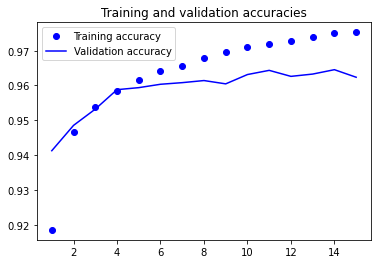

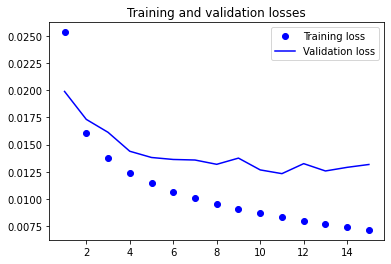

In [49]:
# Write your code
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Reload your best model

In [272]:
# Write your code
from tensorflow import keras

model = keras.models.load_model('lab6.keras')

You will apply your network to one sentence.

In [273]:
sentence = 'The United States might collapsez'.lower().split()

First convert the sentence into indices

In [274]:
# Write your code
inx_sentence = list()
for word in sentence:
    if word in word2idx:
        inx_sentence.append(word2idx[word])
    else:
        inx_sentence.append(1)

Apply the prediction

In [286]:
# Write your code
sent_ner_predictions = model.predict([inx_sentence])


In [287]:
sent_ner_predictions.shape

(1, 5, 10)

Decode the word and tag indices

In [293]:
# Write your code
for word, ner_prediction in zip(sentence, sent_ner_predictions[0]):
    print(word, ' : ', idx2ner[np.argmax(ner_prediction)])

the  :  O
united  :  I-LOC
states  :  I-LOC
might  :  O
collapsez  :  O


## Evaluating your System

You will now evaluate the performance of your system on the whole test set. You will use the official script.
<ol>
    <li>Use the <tt>predict</tt> method to predict the tags of the whole test set
    </li>
    <li>Write your results in a file, where the two last columns will be the hand-annotated tag
        and the predicted tag. The fields must be separated by a space and each line must end with a new line:
        <tt>\n</tt>.
    </li>
    <li>
        If you save your results on a Windows machine, Python will use the default end-of-line sequence: <tt>\r\n</tt>.
        You will then need either to convert your file or to modify the way you save your file.
    </li>
    <li>Apply <tt>conlleval</tt> to your output. Report the F1 result.<br/>
        Be aware that <tt>conlleval</tt> was designed for Unix and will break
    with Windows end-of-line conventions.</li>
    <li>Try to improve your model by modifying some parameters, adding layers, adding
        <tt>Bidirectional</tt>
        and <tt>Dropout</tt>.
    </li>
    <li>
        Evaluate your network again
    </li>
</ol>

First translate the input part of the test set, the words, into lists of words, `X_test_symbs`, lists of indices, `X_test_idx`, and a matrix of indices, where you will pad the sequences: `X_test_padded`

The symbols

In [370]:
# Test
X_test_symbs, Y_test_symbs = build_sequences(test_dict, key_x='form', key_y='ner')
print('X_test:', X_test_symbs[1])
print('Y_test', Y_test_symbs[1])

X_test: ['soccer', '-', 'japan', 'get', 'lucky', 'win', ',', 'china', 'in', 'surprise', 'defeat', '.']
Y_test ['O', 'O', 'I-LOC', 'O', 'O', 'O', 'O', 'I-PER', 'O', 'O', 'O', 'O']


The indices

In [373]:
import tensorflow
X_test_idx = []
#print(word2idx)
for sentence in X_test_symbs:
  local = []
  for word in sentence:
    if word in word2idx:
      local.append(word2idx[word])
    else:
      local.append(1)
  X_test_idx.append(local)

X_test_padded = tensorflow.keras.preprocessing.sequence.pad_sequences(
  X_test_idx, maxlen=150, dtype='int32', padding='post',
  truncating='pre', value=0.0
)

In [ ]:
# print('Predictions', Y_test_hat_probs[1])

Predictions [[1.2249970e-08 3.3408359e-08 1.0807129e-06 ... 3.2240015e-03
  7.2276657e-06 9.9319553e-01]
 [2.2210155e-10 3.4949341e-10 1.5463007e-07 ... 3.4067221e-04
  2.0880318e-04 9.9902940e-01]
 [9.7668869e-09 3.8468118e-09 1.6969406e-07 ... 3.4166221e-02
  1.7162025e-03 8.0466941e-03]
 ...
 [3.3347903e-15 4.3808078e-15 3.3322396e-12 ... 3.3078271e-05
  7.4312666e-06 9.9995351e-01]
 [3.3347903e-15 4.3808078e-15 3.3322396e-12 ... 3.3078271e-05
  7.4312666e-06 9.9995351e-01]
 [3.3347903e-15 4.3808078e-15 3.3322396e-12 ... 3.3078271e-05
  7.4312666e-06 9.9995351e-01]]


In [374]:
print('X_test_idx:', X_test_idx[1])
print('X_test_padded:', X_test_padded[1])

X_test_idx: [338644, 679, 197600, 162137, 229067, 390518, 517, 100680, 190291, 350949, 120818, 936]
X_test_padded: [338644    679 197600 162137 229067 390518    517 100680 190291 350949
 120818    936      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0     

In [375]:
X_test_padded.shape

(3684, 150)

Now predict the whole test set with `predict` and set the results in `Y_test_hat_probs`

In [379]:
# Write your code
# We evaluate on all the test corpus
Y_test_hat_probs = model.predict(X_test_padded)

right_ner = []
right_word = []
for i, sentence in enumerate(dev_dict):
    right_ner.append([])

    for word in sentence:
        right_ner[i].append(word['ner'])


In [380]:
print('Predictions', Y_test_hat_probs[1])

Predictions [[5.0186527e-06 9.1153470e-06 1.5161219e-05 ... 1.9695009e-03
  1.3017810e-04 9.9760687e-01]
 [8.1152564e-08 3.7804702e-07 3.0587543e-07 ... 2.8011631e-04
  1.0045509e-05 9.9964893e-01]
 [5.0258084e-05 6.3309904e-05 5.8099475e-05 ... 4.9769595e-02
  1.7844450e-02 3.0580003e-04]
 ...
 [9.9999964e-01 1.2150278e-07 1.0317748e-07 ... 9.0475666e-10
  1.3264552e-08 8.9357778e-11]
 [9.9999964e-01 1.2150255e-07 1.0317728e-07 ... 9.0475494e-10
  1.3264527e-08 8.9357612e-11]
 [9.9999964e-01 1.2150278e-07 1.0317748e-07 ... 9.0475666e-10
  1.3264552e-08 8.9357778e-11]]


Extract the indices with the highest probabilities from the lists and convert them into NER values. Use the original length of each sentence to discard the padded part of `y` sequences. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [381]:
# write your code
idx2ner[0] = "padding"
idx2ner[1] = "unknown"

predicted_indices = []
for sentence in Y_test_hat_probs:
  local = []
  for word in sentence:
    best_ner = np.argmax(word)
    local.append(idx2ner[best_ner])
  predicted_indices.append(local)

In [382]:
for i in range(len(predicted_indices)):
  predicted_indices[i] = predicted_indices[i][0:len(test_dict[i])]
for i in range(len(test_dict)):
  for j in range(len(test_dict[i])):
    test_dict[i][j]['pner'] = predicted_indices[i][j]


In [384]:
ARCH = '1'
outfile = 'test' + ARCH + '.out'

In [385]:
column_names = ['form', 'ppos', 'pchunk', 'ner', 'pner']

In [386]:
def save(file, corpus_dict, column_names):
    """
    Saves the corpus in a file
    :param file:
    :param corpus_dict:
    :param column_names:
    :return:
    """
    i = 0
    with open(file, 'w', encoding='utf8') as f_out:
        i += 1
        for sentence in corpus_dict:
            sentence_lst = []
            for row in sentence:
                items = map(lambda x: row.get(x, '_'), column_names)
                sentence_lst += ' '.join(items) + '\n'
            sentence_lst += '\n'
            f_out.write(''.join(sentence_lst))

In [387]:
save(outfile, test_dict, column_names)

In [388]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
baseline_score = res['overall']['chunks']['evals']['f1']
baseline_score

0.5357815442561206

## Building a LSTM Network

1. Create a simple LSTM network and train a model with the train set. As layers, you will use <tt>Embedding</tt>, <tt>LSTM</tt>, and <tt>Dense</tt>.
2. Apply conlleval to your output. Report the F1 result.
3. Try to improve your model by modifying some parameters, adding layers, adding <tt>Bidirectional</tt>, <tt>Dropout</tt>, possibly mixing <tt>SimpleRNN</tt>.
4. Apply your network to the test set and report the accuracy you obtained. you need to reach a F1 of 82 to pass.

In [389]:
# Write your code
model2 = keras.Sequential(
    [
        layers.Embedding(402597,100, embeddings_initializer=keras.initializers.Constant(
        value=embedding_matrix), mask_zero=True),
        layers.Dropout(0.4),
        layers.Bidirectional(layers.LSTM(100, return_sequences=True)),
        layers.Dropout(0.3),
        layers.Dense(10, activation="softmax"),
    ]
)


Compile it

In [390]:
# Write your code
model2.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])


In [391]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 100)         40259700  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 200)         160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
dense_9 (Dense)              (None, None, 10)          2010      
Total params: 40,422,510
Trainable params: 40,422,510
Non-trainable params: 0
_________________________________________________________________


Write a callback to store your best model. Call it `lstm.keras`

In [392]:
# Write your code
from tensorflow import keras
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="lstm1.keras",
        save_best_only=True,
        monitor="val_loss")
]

Fit your model

In [393]:
# Write your code
history = model2.fit(
    X_train_padded, Y_train_padded_vectorized,
    epochs=15,
    validation_data=(X_dev_padded, Y_dev_padded_vectorized),
    callbacks=callbacks,
    )

Epoch 1/15
469/469 [==============================] - 176s 338ms/step - loss: 0.0264 - accuracy: 0.9126 - val_loss: 0.2351 - val_accuracy: 0.2962
Epoch 2/15
469/469 [==============================] - 156s 332ms/step - loss: 0.0150 - accuracy: 0.9495 - val_loss: 0.2404 - val_accuracy: 0.3343
Epoch 3/15
469/469 [==============================] - 188s 401ms/step - loss: 0.0121 - accuracy: 0.9588 - val_loss: 0.2223 - val_accuracy: 0.3622
Epoch 4/15
469/469 [==============================] - 149s 317ms/step - loss: 0.0104 - accuracy: 0.9642 - val_loss: 0.2157 - val_accuracy: 0.3983
Epoch 5/15
469/469 [==============================] - 118s 252ms/step - loss: 0.0093 - accuracy: 0.9678 - val_loss: 0.1792 - val_accuracy: 0.4643
Epoch 6/15
469/469 [==============================] - 141s 300ms/step - loss: 0.0085 - accuracy: 0.9704 - val_loss: 0.2063 - val_accuracy: 0.4325
Epoch 7/15
469/469 [==============================] - 146s 311ms/step - loss: 0.0077 - accuracy: 0.9730 - val_loss: 0.1850 -

Create a figure to show the training and validation losses and accuracies and comment on a possible overfit.

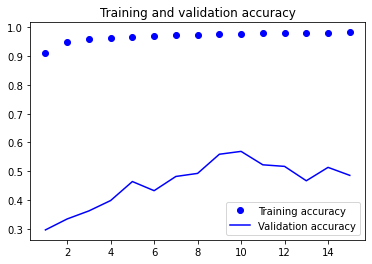

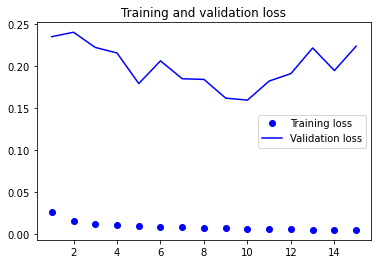

In [394]:
# Write your code
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


Reload your best model

In [395]:
# Write your code
test_model = keras.models.load_model('lstm1.keras')


Predict the NER sequence

In [396]:
# Write your code
# We evaluate on all the test corpus
Y_test_hat_probs = test_model.predict(X_test_padded)

idx2ner[0] = "padding"
idx2ner[1] = "unknown"

predicted_indices = []
for sentence in Y_test_hat_probs:
  local = []
  for word in sentence:
    best_ner = np.argmax(word)
    local.append(idx2ner[best_ner])
  predicted_indices.append(local)


Extract the indices of the highest probabilities from the lists and convert them into NER values. Add them with the `pner` key to the dictionaries in the `test_dict` list.

In [397]:
# write your code
for i in range(len(test_dict)):
  for j in range(len(test_dict[i])):
    test_dict[i][j]['pner'] = predicted_indices[i][j]


In [398]:
ARCH = '4'
outfile = 'test' + ARCH + '.out'

In [399]:
save(outfile, test_dict, column_names)

In [400]:
lines = open(outfile, encoding='utf8').read().splitlines()
res = conlleval.evaluate(lines)
improved_score = res['overall']['chunks']['evals']['f1']
improved_score

0.8398908546782853

You need to reach 82 to pass the assignment.